In [5]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold._t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [6]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)

    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)

    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))

    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c

    return kl_divergence, grad


def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
              " gradient norm = %.7f"
              % (i + 1, error, grad_norm))

        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break

        if grad_norm <= min_grad_norm:
            break

    return p


def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    obj_func = _kl_divergence
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded


def fit(X):
    n_samples = X.shape[0]
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)

    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)

    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)

    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)

    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)


In [7]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
palette = sns.color_palette("bright", 10)

X, y = load_digits(return_X_y=True)

MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 3
perplexity = 30

[t-SNE] Iteration 1: error = 3.9810953, gradient norm = 0.0000043
[t-SNE] Iteration 2: error = 3.9810953, gradient norm = 0.0000044
[t-SNE] Iteration 3: error = 3.9810953, gradient norm = 0.0000049
[t-SNE] Iteration 4: error = 3.9810953, gradient norm = 0.0000066
[t-SNE] Iteration 5: error = 3.9810952, gradient norm = 0.0000101
[t-SNE] Iteration 6: error = 3.9810952, gradient norm = 0.0000166
[t-SNE] Iteration 7: error = 3.9810949, gradient norm = 0.0000288
[t-SNE] Iteration 8: error = 3.9810942, gradient norm = 0.0000524
[t-SNE] Iteration 9: error = 3.9810913, gradient norm = 0.0001000
[t-SNE] Iteration 10: error = 3.9810800, gradient norm = 0.0001996
[t-SNE] Iteration 11: error = 3.9810308, gradient norm = 0.0004153
[t-SNE] Iteration 12: error = 3.9808006, gradient norm = 0.0008980
[t-SNE] Iteration 13: error = 3.9796425, gradient norm = 0.0020068
[t-SNE] Iteration 14: error = 3.9734800, gradient norm = 0.0045415
[t-SNE] Iteration 15: error = 3.9409453, gradient norm = 0.0095387
[t-S

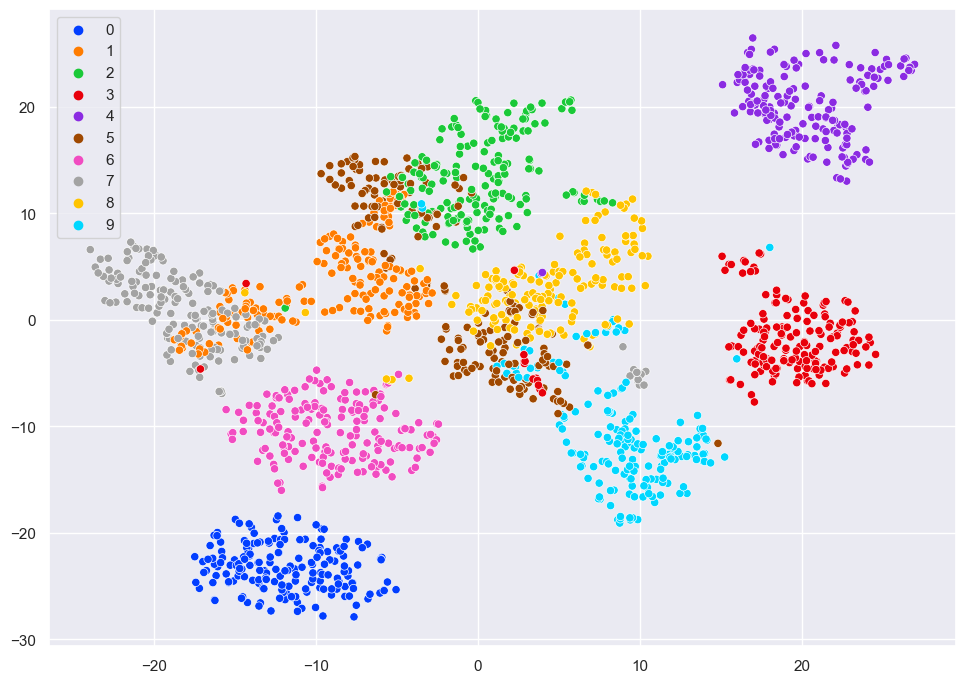

In [8]:
X_embedded = fit(X)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.show()